# 캐글 프로젝트 

### 라이브러리 버전 확인

In [1]:
import xgboost
import lightgbm
import missingno
import sklearn

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


### 튜닝해볼 수 있는 모델 클래스 인자

- 자주 튜닝하는 라이브러리는 lightgbm이 있다. 
    - max_depth : 의사 결정 나무의 깊이, 정수 사용
    - learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
    - n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
    - num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
    - boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

### lightGBM /XGBoost 파라미터 설명
- 참고자료 1 : http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
- 참고자료 2 : https://injo.tistory.com/48


__LightGBM에서 튜닝해주는 것이 좋은 파라미터__
1. Learning_rate, eta, 훈련량
1. num_iterations/nrounds, 반복량
1. early_stopping_round/early_stopping_rounds, 조기멈춤

__LightGBM의 장단점__
1. 장점
    1. XGBoost 대비 더 빠른 학습과 예측 수행 시간
    1. 더 작은 메모리 사용량
    1. 카테고리형 피처의 자동 변환과 최적 분할 ; 원핫 인코딩 등 사용한해도 됨

1. 단점
    1. 데이터 크기가 작으면 과적합 발생이 쉬움
    1. 공식문서상 대략 10,000건 이하
    
1. 기존 GBM과의 차이점
    1. 리프중심 트리분할(Leaf Wise) 방식
    1. 최대 손실 값을 가지는 리프노드를 지속적으로 분할
    1. 예측 오류 손실을 최소화
    
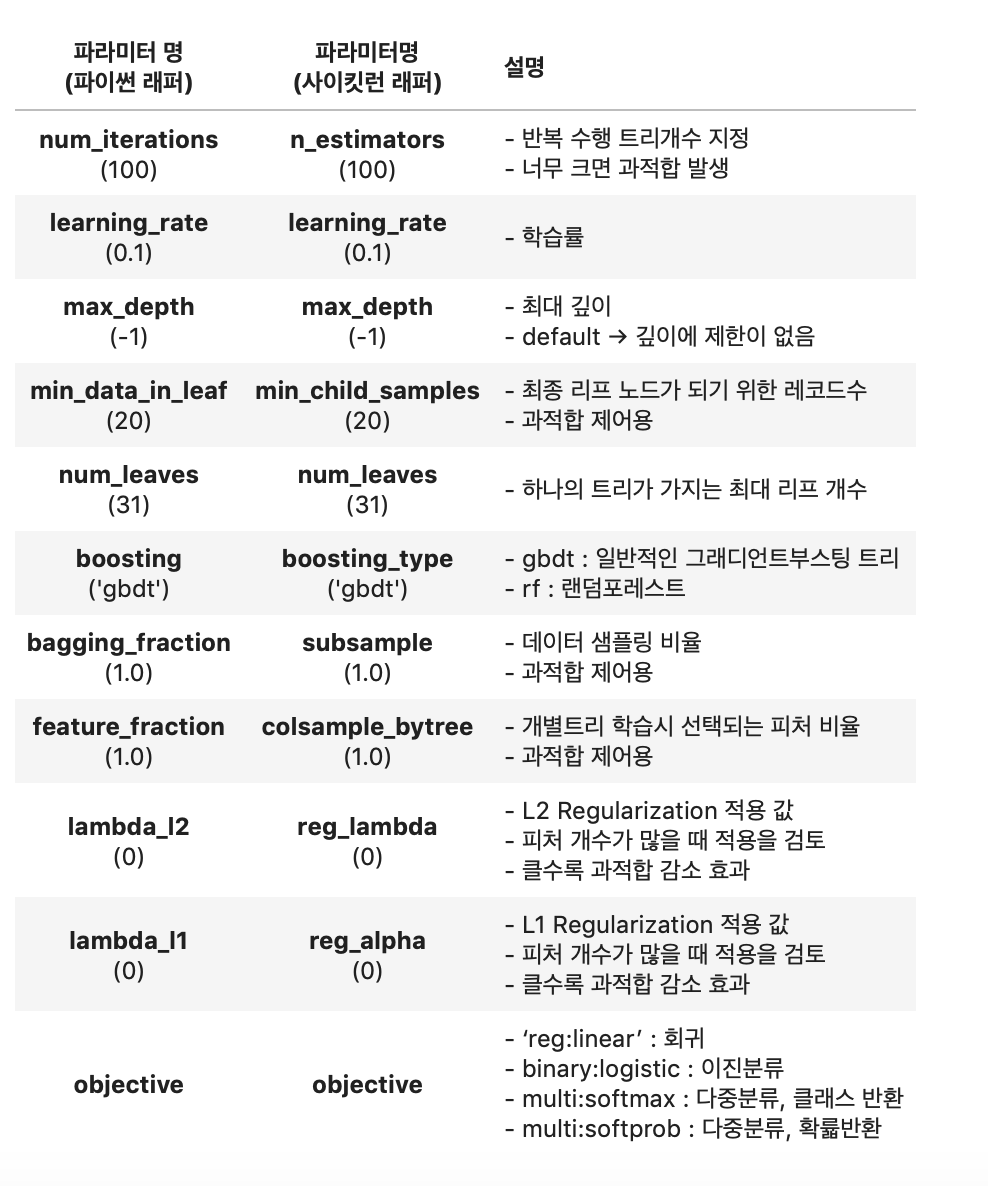

### 시도해볼 수 있는 방법

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용햇던 블렌딩 방법 활용하기

### 프로젝트 루브릭
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 __Private score 기준 110000이하의 점수__를 얻었는가?

# House Price Prediction
- 레퍼런스 :  https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook

### EDA

__라이브러리__

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

__데이터 불러오기__

In [4]:
# # 훈련세트, 테스트세트, 제출예시 불러오기
# train = pd.read_csv('data/train.csv')
# test = pd.read_csv("data/test.csv")
# sample_submission = pd.read_csv("data/sample_submission.csv")

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [6]:
# 트레인 세트 확인
pd.set_option("display.max_columns", 50)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
print("훈련세트 피쳐 : ")
print([i for i in train.columns])
print("훈련세트 크기 : ",train.shape)

훈련세트 피쳐 : 
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
훈련세트 크기 :  (15035, 21)


In [8]:
# 테스트 세트
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
print("테스트세트 피쳐 : ")
print([i for i in test.columns])
print("테스트세트 크기 : ",test.shape)

테스트세트 피쳐 : 
['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
테스트세트 크기 :  (6468, 20)


__데이터 살펴보기__

1. ID : 집을 구분하는 번호
1. date : 집을 구매한 날짜
1. price : __타겟__ 변수인 집의 가격
1. bedrooms : 침실의 수
1. bathrooms : 침실당 화장실 개수
1. sqft_living : 주거 공간의 평방 피트
1. sqft_lot : 부지의 평방 피트
1. floors : 집의 층 수
1. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
1. view : 집이 얼마나 좋아 보이는지의 정도
1. condition : 집의 전반적인 상태
1. grade : King County grading 시스템 기준으로 매긴 집의 등급
1. sqft_above : 지하실을 제외한 평방 피트
1. sqft_basement : 지하실의 평방 피트
1. yr_built : 집을 지은 년도
1. yr_renovated : 집을 재건축한 년도1
1. zipcode : 우편번호
1. lat : 위도
1. long : 경도
1. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
1. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [10]:
# 훈련데이터에서 타겟을 변수 y에 저장
y = train["price"]
del train["price"]

### 전처리

__결측치 확인__

<AxesSubplot:>

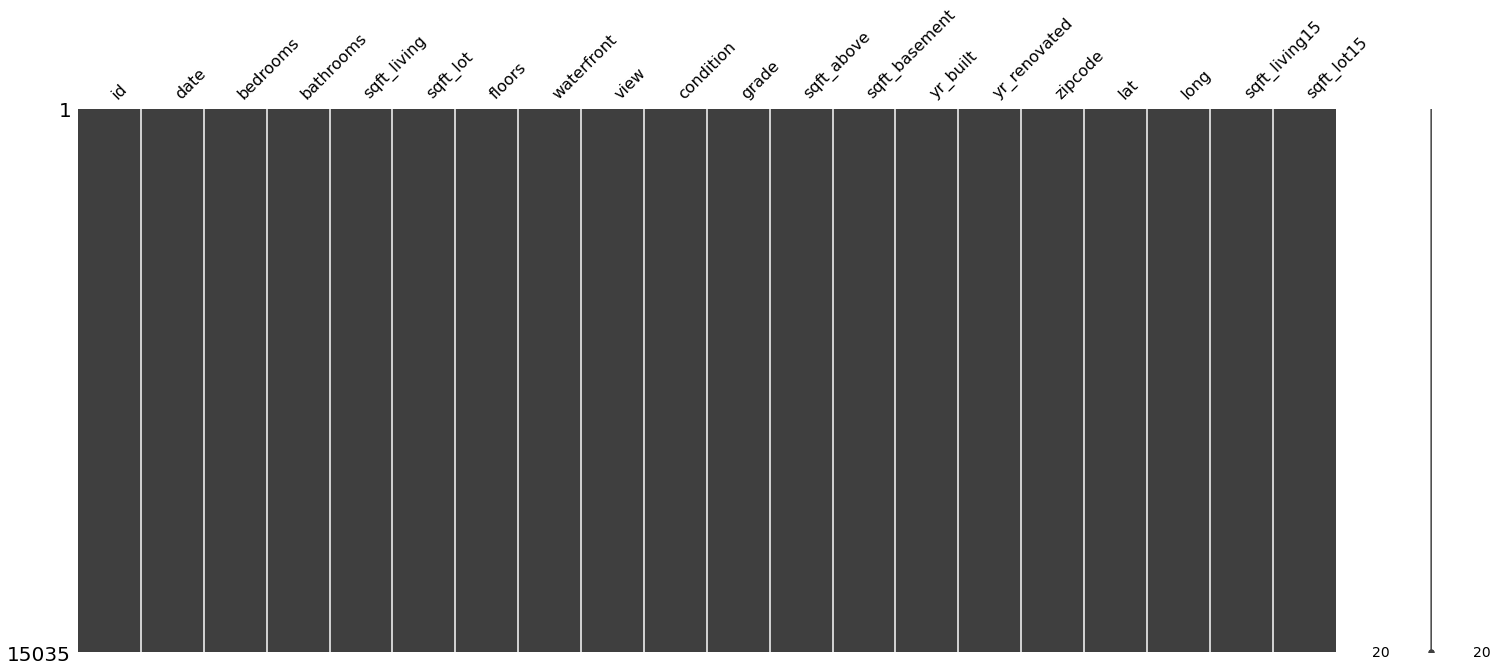

In [11]:
msno.matrix(train)

In [12]:
# 좀 더 상세하게 결측치 확인
for i in train.columns:
    print(f"{i} : {len(train[train[i].isnull()])}")

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [13]:
# 테스트 결측치 확인
for i in test.columns:
    print(f"{i} : {len(test[train[i].isnull()])}")

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


__id, date 변수 정리__

In [14]:
# id 정리
del train["id"]
sub = test[["id"]]
del test["id"]

In [15]:
# date정리
# 뒷부분의 t000000부분 정리
train["date"] = train["date"].str[:8].astype(int)
train[["date"]]

,date
0,20141013
1,20150225
2,20150218
3,20140627
4,20150115
...,...
15030,20141014
15031,20150326
15032,20140521
15033,20150223


In [16]:
# test 데이터도 정리
test["date"] = test["date"].str[:8].astype(int)
test[["date"]]

,date
0,20141209
1,20141209
2,20140512
3,20150415
4,20150312
...,...
6463,20140626
6464,20150126
6465,20150219
6466,20140623


__yr_built, waterfront, zipcode 더미화__ 

In [17]:
train = pd.get_dummies(train, columns = ['yr_built', 'waterfront', 'zipcode'])
test = pd.get_dummies(test, columns = ['yr_built', 'waterfront', 'zipcode'])

In [18]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_built_1900,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,...,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,20141013,3,1.00,1180,5650,1.0,0,3,7,1180,0,0,47.5112,-122.257,1340,5650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,20150225,2,1.00,770,10000,1.0,0,3,6,770,0,0,47.7379,-122.233,2720,8062,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20150218,3,2.00,1680,8080,1.0,0,3,8,1680,0,0,47.6168,-122.045,1800,7503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20140627,3,2.25,1715,6819,2.0,0,3,7,1715,0,0,47.3097,-122.327,2238,6819,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20150115,3,1.50,1060,9711,1.0,0,3,7,1060,0,0,47.4095,-122.315,1650,9711,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,20141014,4,2.50,2520,6023,2.0,0,3,9,2520,0,0,47.5137,-122.167,2520,6023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15031,20150326,4,3.50,3510,7200,2.0,0,3,9,2600,910,0,47.5537,-122.398,2050,6200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15032,20140521,3,2.50,1530,1131,3.0,0,3,8,1530,0,0,47.6993,-122.346,1530,1509,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15033,20150223,4,2.50,2310,5813,2.0,0,3,8,2310,0,0,47.5107,-122.362,1830,7200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


__각 변수들의 분포 확인__

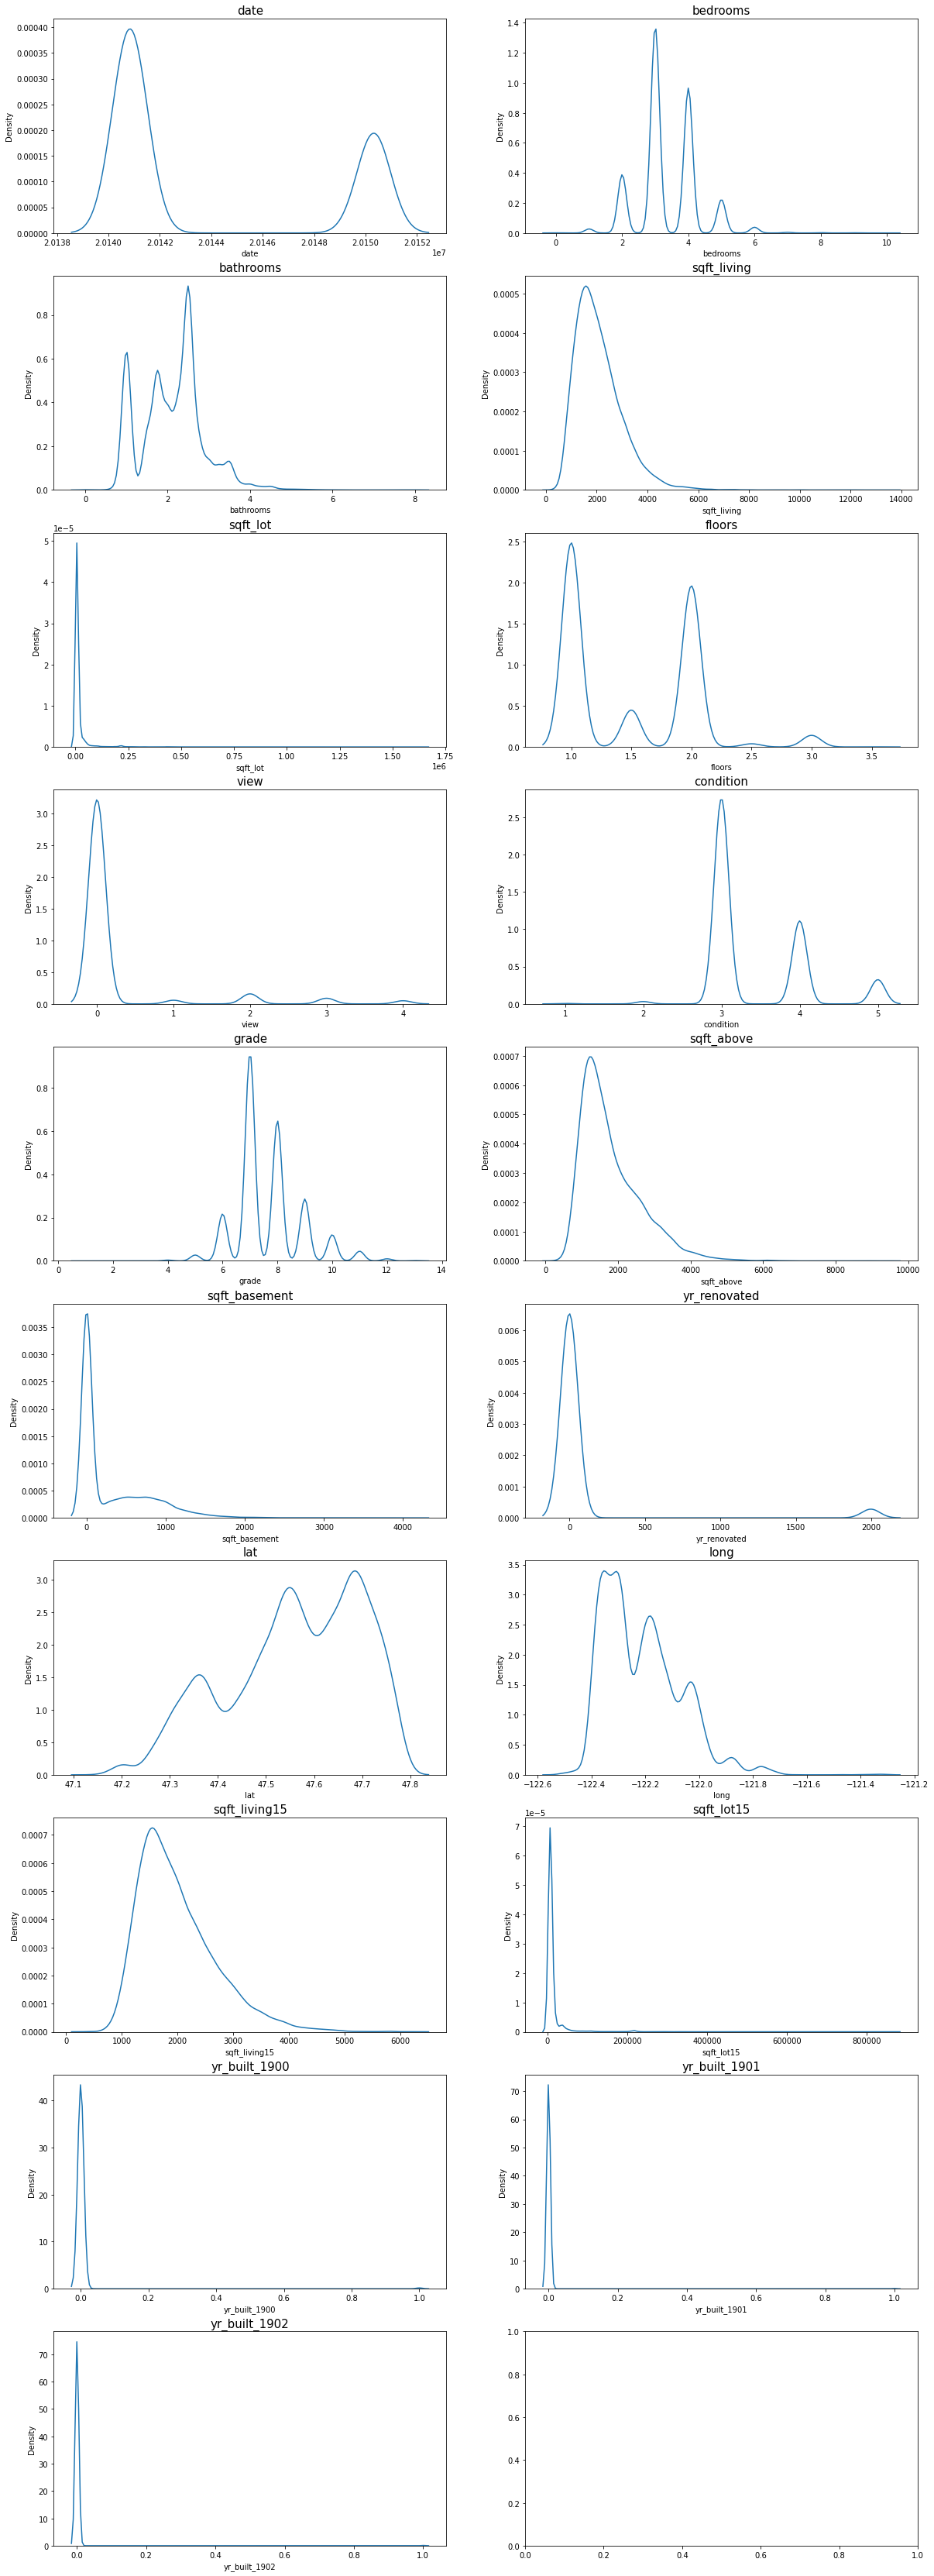

In [19]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

__정규화 진행__
- price, bedrooms, sqft_living, sqft_lot, sqft_lot, sqft_above, sqft_basement 변수가 한 쪽으로 치우친 경향을 보여서 log scaling 을통해 정규화

In [20]:
# 훈련세트 변경
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [21]:
# 타겟도 로그화
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [22]:
# 테스트 세트 변경
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

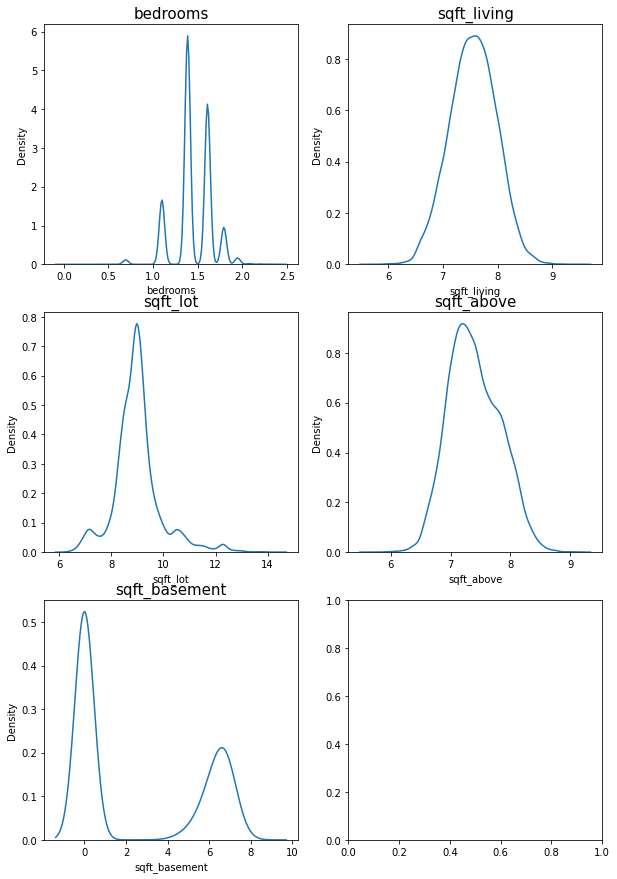

In [23]:
# 정규화된 그래프
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

### 모델링

__Average Blending__
- 3가지 모델의 산술평균을 통해 Blending 모델을 만들겠습니다.

In [24]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [25]:
# random_state 고정
random_state = 2019

In [26]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(max_depth=_10,nestimators = 100,random_state=random_state)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [27]:
# 그리드 서치
def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # 1. GridSearchCV 모델로 'model'을 초기화합니다. 
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring = 'neg_mean_squared_error', \
                        cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]
    
    # 데이터 프레임을 생성하고,  
    params_score = pd.DataFrame(params)
    params_score["score"] = score
    
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬하고 값을 반환한다.
    params_score["RMSLE"] = np.sqrt(-score)
    params_score.sort_values(by="RMSLE", ascending = False, inplace = True)
    
    return params_score

__Cross Validation__
- K-fold 검증을 통해 모델 검증

In [28]:
def get_cv_score(models, x, y):
    kfold = KFold(n_splits=5, random_state=random_state, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), kf=kfold))

In [29]:
# 점수 평가
get_cv_score(models, train, y)

Model GradientBoosting CV score : 0.8795
Model XGBoost CV score : 0.8970
Model LightGBM CV score : 0.9021


__제출파일 만들기__

In [30]:
# sample_submission 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [42]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [43]:
def AveragingBlending(models, x, y, test):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    y_pred = np.mean(predictions, axis=1)
    y_pm = np.expm1(y_pred)
    return y_pm

In [44]:
y_pred = AveragingBlending(models, train, y, test)

In [45]:
submission["price"] = y_pred
# sub.set_index("id", drop = True, inplace = True)
submission

,id,price
0,15035,5.319752e+05
1,15036,4.925358e+05
2,15037,1.255137e+06
3,15038,3.329343e+05
4,15039,3.329528e+05
...,...,...
6463,21498,2.464690e+05
6464,21499,4.120156e+05
6465,21500,4.539867e+05
6466,21501,3.167746e+05


In [46]:
# sub.merge(sample_submission, how = "inner", on = "id")

In [47]:
# sample_submission

In [48]:
sub.to_csv("tj_submission.csv")

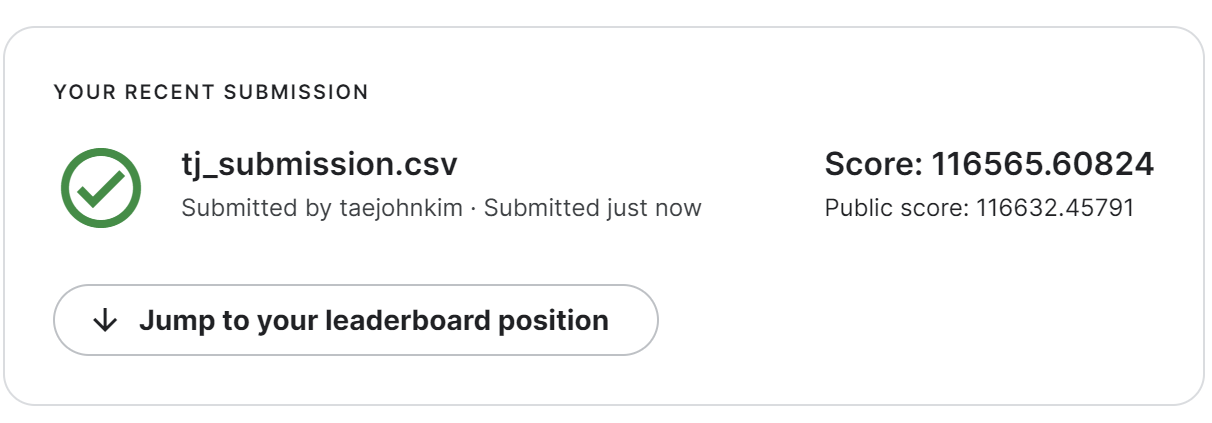